In [1]:
import os
os.chdir("..")

<h3> Load Libraries </h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.plots import plot_adaptive_evolution, plot_return_period_summary, plot_two_return_period_summaries
from production.utils import summarize_depths_by_return_period
from production.metrics import metrics

<h3> Preprocess data </h3>

In [3]:
watershed_name = "Trinity"

In [4]:
watershed = Preprocessor(config_path = f"/workspaces/Importance-Sampling-for-SST/data/0_source/{watershed_name}/config.json", 
                       output_folder = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}")
watershed.run()

FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/config.json'

In [ ]:
watershed = Preprocessor.load(config_path = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/config.json")

<h3> Full Monte Samples </h3>

In [5]:
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=20_000,
    num_realizations=1,
)

fullmonte_samples = sampler.sample(data = watershed)

NameError: name 'watershed' is not defined

In [ ]:
fullmonte_depths = StormDepthProcessor(watershed).run(fullmonte_samples, n_jobs=-1)

#Save
#fullmonte_depths.to_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/fullmonte_depths.pq")

In [5]:
#Read
fullmonte_depths = pd.read_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/fullmonte_depths.pq")

In [6]:
#Summarise precipitation frequency 2-2000 year return periods
fullmonte_summary = summarize_depths_by_return_period(
    df=fullmonte_depths,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
)

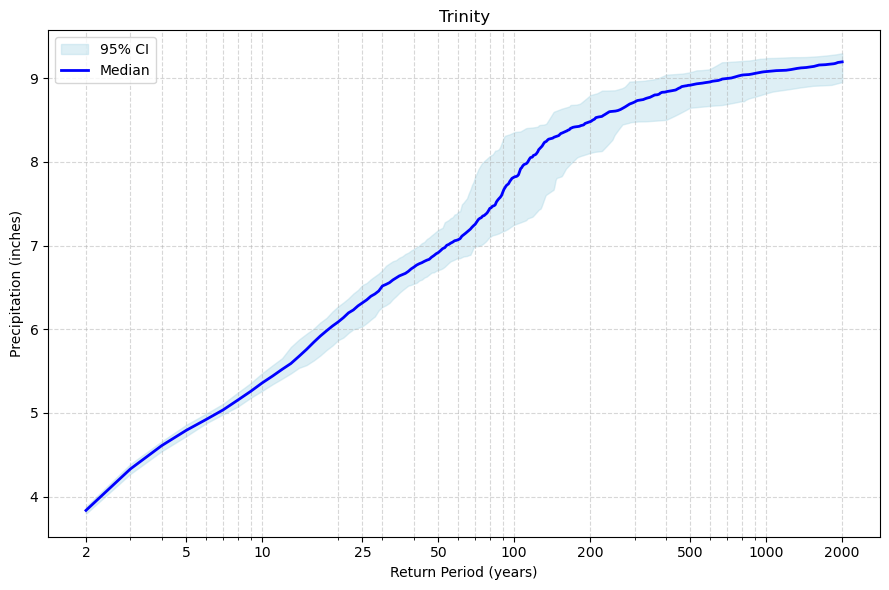

In [8]:
plot_return_period_summary(fullmonte_summary, title="Trinity")

<h3> Importance Sampling - Truncated Normals </h3>

In [7]:
num_simulations = 15_000

In [ ]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"]*0.7,
    "sd_y": watershed.watershed_stats["range_y"]*0.35,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=num_simulations,
    num_realizations=50,
)

TruncNorm_samples = sampler.sample(data = watershed)

In [10]:
TruncNorm_depths = StormDepthProcessor(watershed).run(TruncNorm_samples, n_jobs=-1)

In [16]:
#Save
TruncNorm_depths.to_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/TruncNorm_depths_N{num_simulations}.pq")

In [8]:
#Read
TruncNorm_depths = pd.read_parquet(f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/TruncNorm_depths_N{num_simulations}.pq")

In [9]:
TruncNorm_summary = summarize_depths_by_return_period(
    df=TruncNorm_depths,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
)

In [13]:
m = metrics(fullmonte_summary,TruncNorm_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,1833,2.0,1834.0,0.013354,0.025789,0.047791,0.038188,0.037794,0.02877,-0.00679,...,-0.034214,0.022345,-0.022171,0.018842,-0.01205,-0.014349,-0.050007,0.001626,-0.028764,0.002195


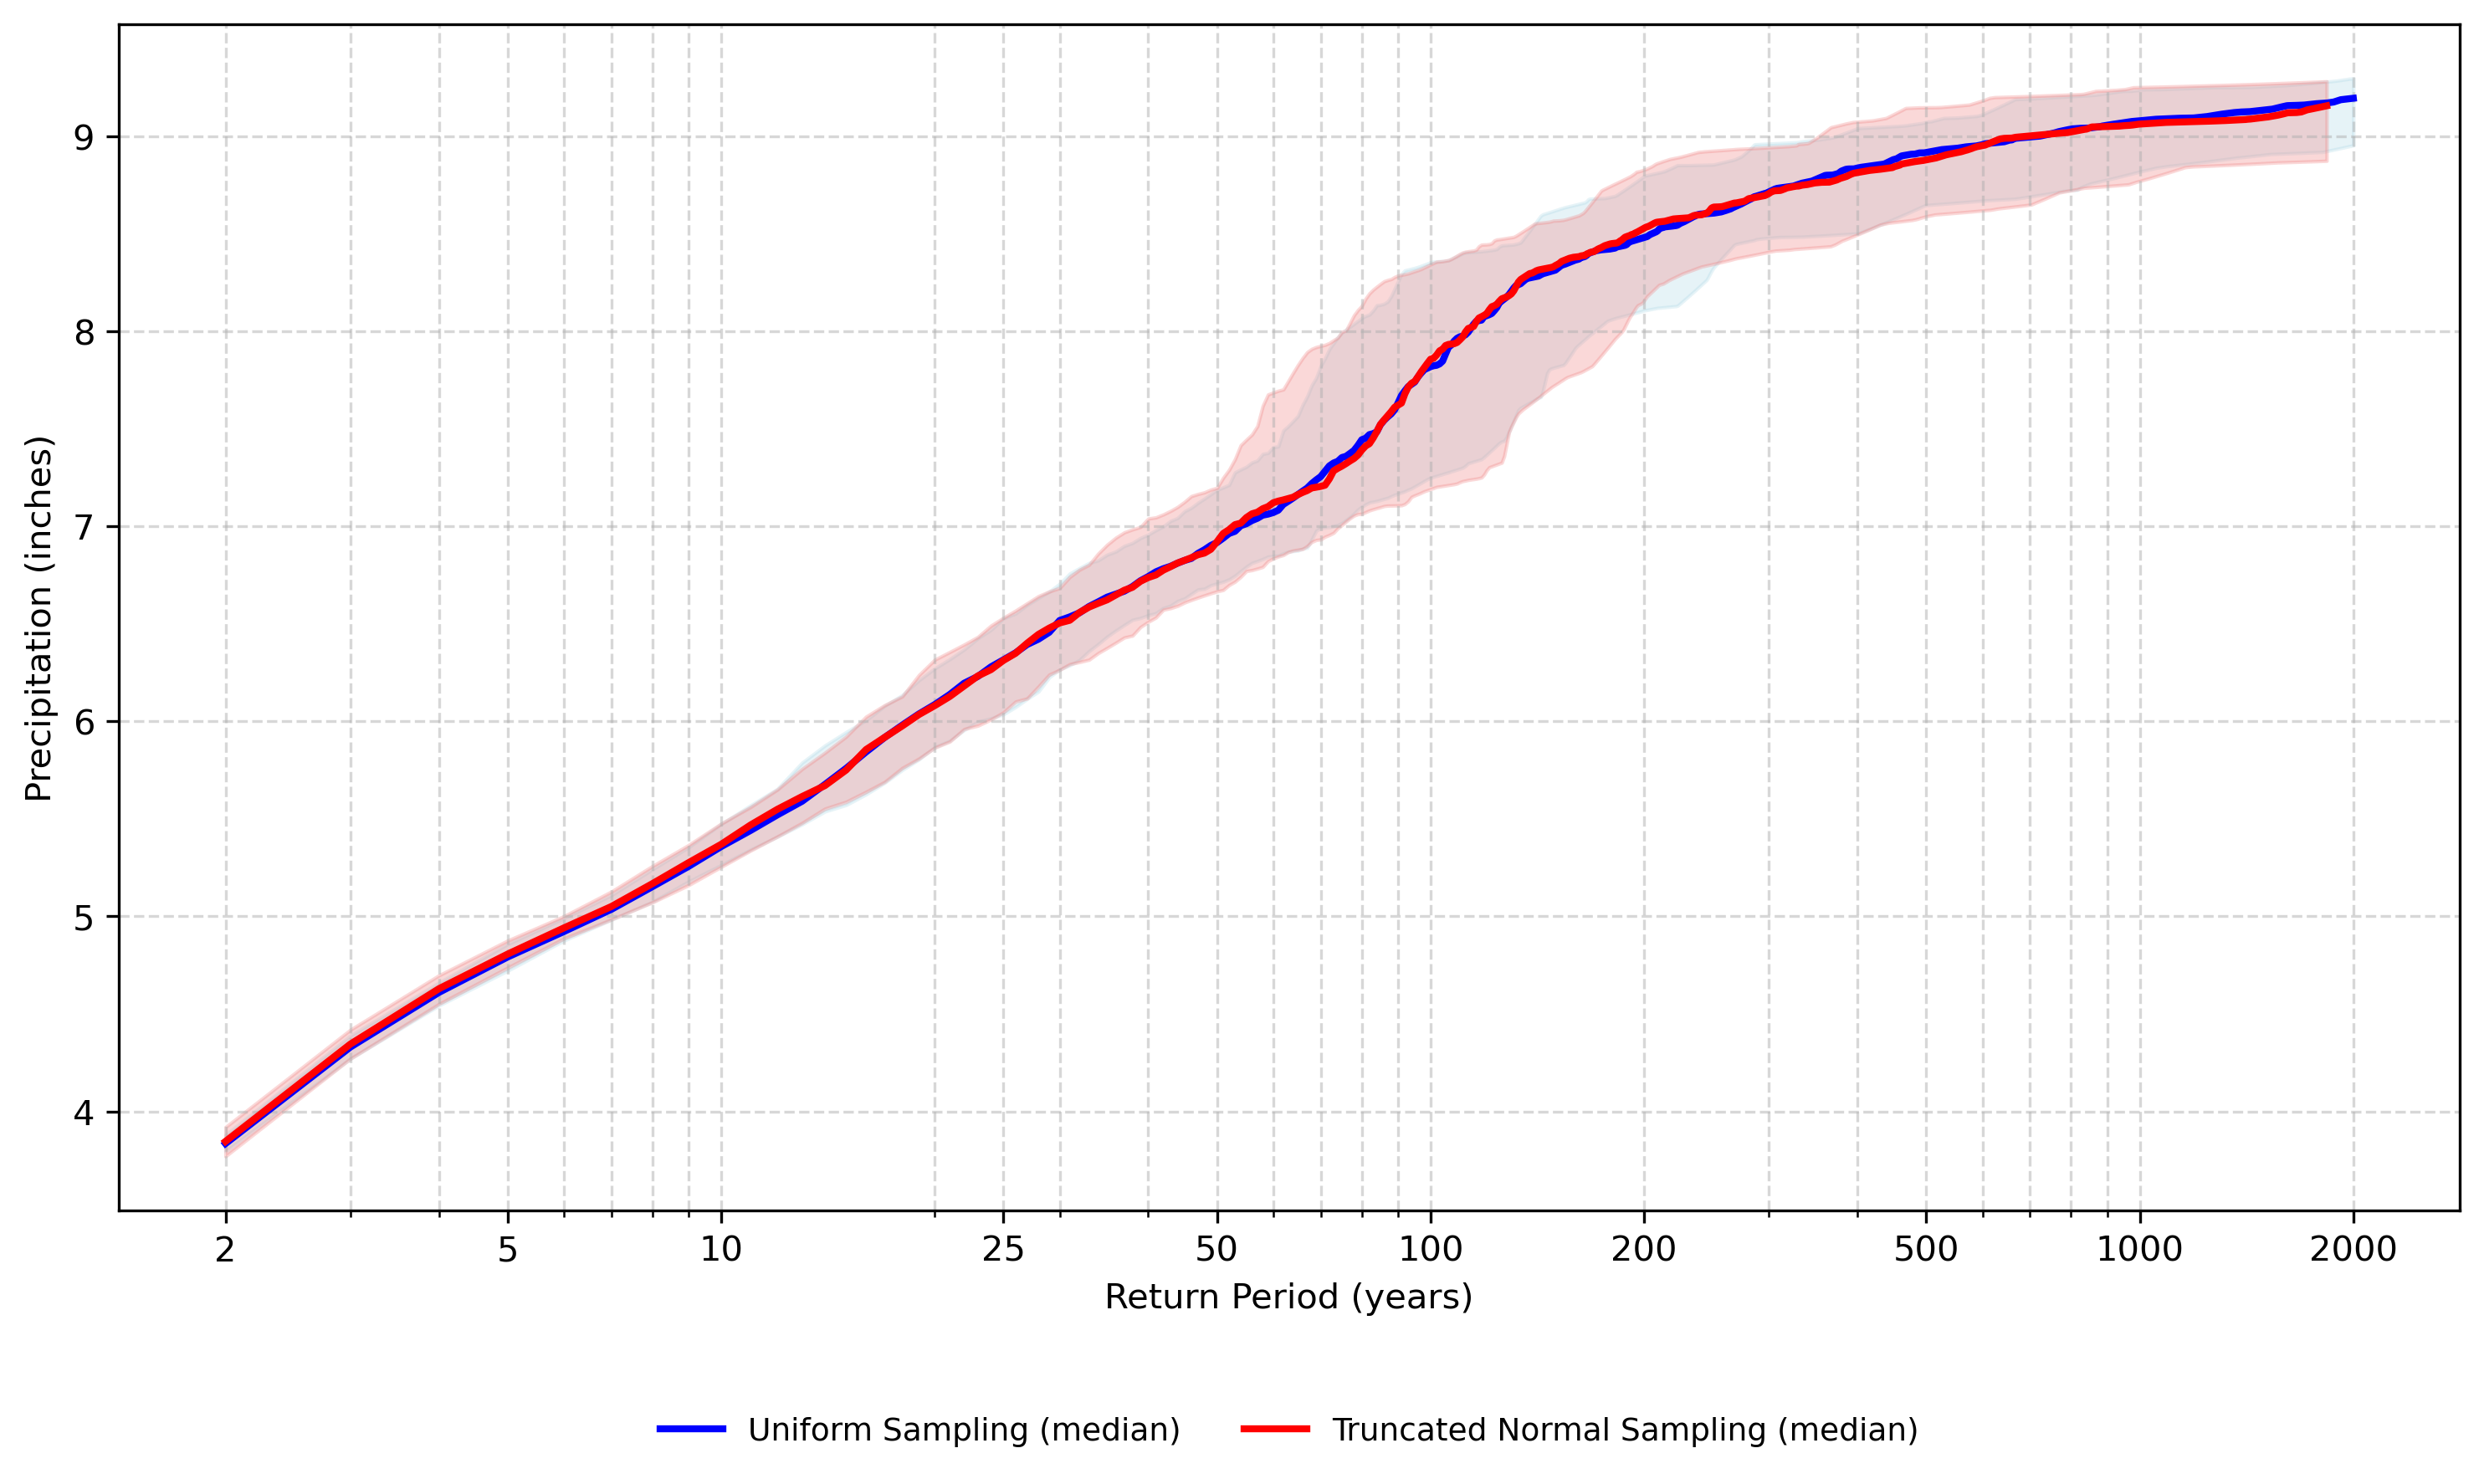

In [11]:
plot_two_return_period_summaries(
    summary1=fullmonte_summary,          # your first summary DataFrame
    summary2=TruncNorm_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Truncated Normal Sampling",
    title=""
)

<h3> Importance Sampling - Gaussian Copula </h3>

In [42]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"],
    "sd_y": watershed.watershed_stats["range_y"]*0.5, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=300_000,
    num_rep=1,
    seed=42,
)

copula_samples = sampler.sample(data = watershed)

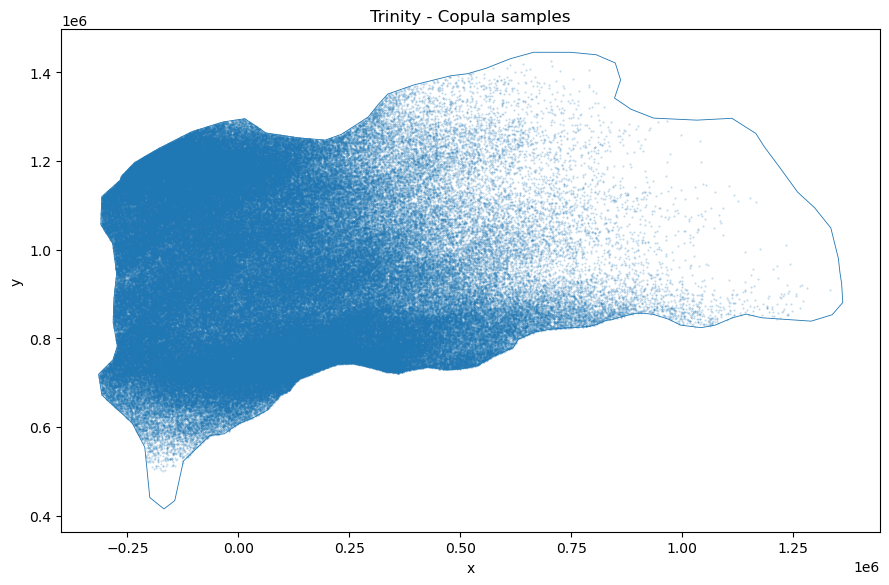

In [45]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(copula_samples.newx, copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [47]:
copula_depths = StormDepthProcessor(watershed).run(copula_samples, n_jobs=-1)

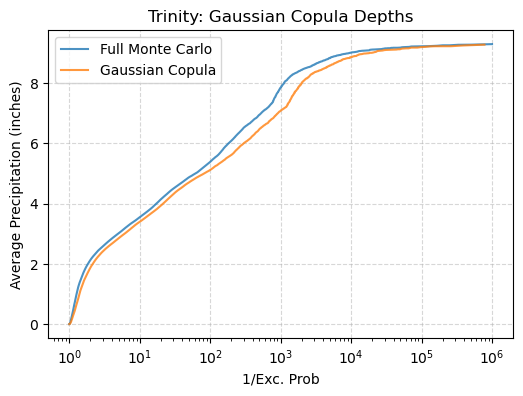

In [48]:
plt.figure(figsize=(6, 4))

for df, label in [
    (fullmonte_depths, "Full Monte Carlo"),
    (TruncNorm_depths, "Gaussian Copula"),
]:
    df = df.sort_values("exc_prb")
    plt.plot(1 / df["exc_prb"], df["precip_avg_mm"] / 25.4, label=label, alpha=0.8)

plt.xscale("log")
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name}: Gaussian Copula Depths")
plt.show()

<h3> Importance Sampling - Mixture</h3>

In [228]:
#Sample
params = {
    "mu_x_narrow": watershed.watershed_stats["x"],  
    "mu_y_narrow": watershed.watershed_stats["y"],
    "mu_x_wide": watershed.domain_stats["x"],  
    "mu_y_wide": watershed.domain_stats["y"],
    "sd_x_narrow": watershed.watershed_stats["range_x"]*0.2,
    "sd_y_narrow": watershed.watershed_stats["range_y"]*0.2,
    "sd_x_wide": watershed.domain_stats["range_x"],
    "sd_y_wide": watershed.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=2_000,
    num_realizations=1,
)

mixture_samples = sampler.sample(data = watershed)

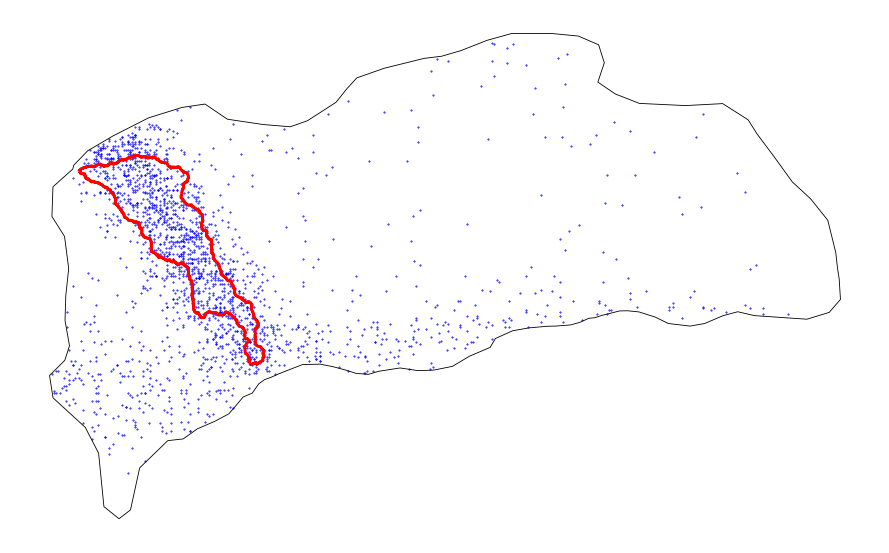

In [236]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,9))

# make figure & axes transparent
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# draw domain outline (black) and watershed outline (red)
watershed.domain_gdf.boundary.plot(ax=ax, linewidth=0.6, color='black')
watershed.watershed_gdf.boundary.plot(ax=ax, linewidth=2, color='red')

# scatter points
ax.scatter(
    mixture_samples.newx,
    mixture_samples.newy,
    s=0.2,
    alpha=1,
    rasterized=False,
    color='blue'
)

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

# show interactively
plt.show()

# save to file with transparent background
fig.savefig("scatter.png", dpi=300, transparent=True)

In [67]:
mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

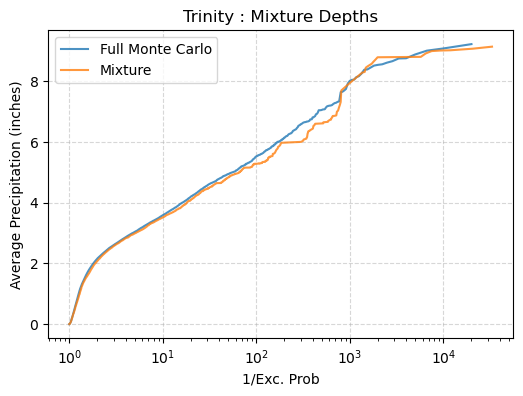

In [68]:
import matplotlib.pyplot as plt

# Sort both datasets by exceedance probability
df_full = fullmonte_depths.sort_values("exc_prb")
df_mixture = mixture_depths.sort_values("exc_prb")

plt.figure(figsize=(6, 4))

# Full Monte Carlo
plt.plot(
    1 / df_full["exc_prb"], 
    df_full["precip_avg_mm"] / 25.4,
    label="Full Monte Carlo",
    alpha=0.8
)

# Truncated Normal
plt.plot(
    1 / df_mixture["exc_prb"], 
    df_mixture["precip_avg_mm"] / 25.4,
    label="Mixture",
    alpha=0.8
)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name} : Mixture Depths") 
plt.show() 

<h3> Importance Sampling - Adaptive Mixture </h3>

In [ ]:
params = AdaptParams(
    # Narrow component starts around watershed centroid
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"]*0.5,
    sd_y_n=watershed.watershed_stats["range_y"]*0.5,

    # Wide component starts around full domain centroid
    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    # Optional extras
    mix=0.5,            # initial mixture weight for narrow
    rho_n=-0.7,         # correlation in narrow copula
    rho_w=0.5,          # correlation in wide copula
)

sampler = AdaptiveMixtureSampler(
    precip_cube=watershed.cumulative_precip,
    storm_centers=watershed.storm_centers,
    watershed_gdf=watershed.watershed_gdf,
    domain_gdf=watershed.domain_gdf,
    params=params,
    seed=42,
)

In [ ]:
history = sampler.adapt(num_iterations=10, samples_per_iter=500)
print(history)

In [ ]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [ ]:
#Do final N required samples from the final distributions
samples = sampler.sample_final(n=100_000, with_depths=True)
print(samples.head()) 

In [1]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"] * 0.5,
    sd_y_n=watershed.watershed_stats["range_y"] * 0.5,

    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    rho_n=-0.7,
    rho_w=0.5,
    mix=0.5,
)

sampler = AdaptiveMixtureSampler(
    precip_cube=watershed.cumulative_precip,   # DataArray/Dataset OR dict is fine
    storm_centers=watershed.storm_centers,
    watershed_gdf=watershed.watershed_gdf,
    domain_gdf=watershed.domain_gdf,
    params=params,
    seed=42,
)

history = sampler.adapt(num_iterations=10, samples_per_iter=500)

NameError: name 'AdaptParams' is not defined